In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, categorical_dim, continuous_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim

        self.fc1 = nn.Linear(latent_dim + categorical_dim + continuous_dim, 1024)
        self.fc2 = nn.Linear(1024, 128 * 7 * 7)
        self.bn2 = nn.BatchNorm1d(128 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, 2, 1)

    def forward(self, z, c1, c2):
        inputs = torch.cat([z, c1, c2], 1)
        x = F.leaky_relu(self.fc1(inputs), 0.2)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        x = x.view(-1, 128, 7, 7)
        x = F.leaky_relu(self.bn3(self.conv1(x)), 0.2)
        x = torch.tanh(self.conv2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, categorical_dim, continuous_dim):
        super(Discriminator, self).__init__()
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(1024, categorical_dim)
        self.fc4 = nn.Linear(1024, continuous_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = x.view(-1, 128 * 7 * 7)
        x = F.leaky_relu(self.bn3(self.fc1(x)), 0.2)
        d = torch.sigmoid(self.fc2(x))
        c1 = self.fc3(x)
        c2 = self.fc4(x)
        return d, c1, c2

class InfoGAN:
    def __init__(self, latent_dim, categorical_dim, continuous_dim, lr=0.0002, beta1=0.5):
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim

        self.generator = Generator(latent_dim, categorical_dim, continuous_dim)
        self.discriminator = Discriminator(categorical_dim, continuous_dim)

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

        self.criterion = nn.BCELoss()
        self.categorical_loss = nn.CrossEntropyLoss()
        self.continuous_loss = nn.MSELoss()

    def train_step(self, real_data):
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator and Q-network
        self.d_optimizer.zero_grad()

        d_real_output, _, _ = self.discriminator(real_data)
        d_real_loss = self.criterion(d_real_output, real_labels)

        z = torch.randn(batch_size, self.latent_dim)
        c1 = torch.zeros(batch_size, self.categorical_dim).scatter_(1, torch.randint(0, self.categorical_dim, (batch_size, 1)), 1)
        c2 = torch.rand(batch_size, self.continuous_dim)
        fake_data = self.generator(z, c1, c2)
        d_fake_output, q_c1, q_c2 = self.discriminator(fake_data.detach())
        d_fake_loss = self.criterion(d_fake_output, fake_labels)

        q_loss = self.categorical_loss(q_c1, torch.max(c1, 1)[1]) + self.continuous_loss(q_c2, c2)
        d_loss = d_real_loss + d_fake_loss + q_loss
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()

        z = torch.randn(batch_size, self.latent_dim)
        c1 = torch.zeros(batch_size, self.categorical_dim).scatter_(1, torch.randint(0, self.categorical_dim, (batch_size, 1)), 1)
        c2 = torch.rand(batch_size, self.continuous_dim)
        fake_data = self.generator(z, c1, c2)
        g_fake_output, q_c1, q_c2 = self.discriminator(fake_data)
        g_loss = self.criterion(g_fake_output, real_labels)
        q_loss = self.categorical_loss(q_c1, torch.max(c1, 1)[1]) + self.continuous_loss(q_c2, c2)
        g_total_loss = g_loss + q_loss
        g_total_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_total_loss.item(), q_loss.item()

def train_infogan(infogan, dataloader, num_epochs, device):
    infogan.generator.to(device)
    infogan.discriminator.to(device)

    for epoch in range(num_epochs):
        for i, (real_data, _) in enumerate(dataloader):
            real_data = real_data.to(device)
            d_loss, g_loss, q_loss = infogan.train_step(real_data)

            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'd_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}, q_loss: {q_loss:.4f}')

def visualize_results(infogan, latent_dim, categorical_dim, continuous_dim, num_samples=10):
    infogan.generator.eval()
    with torch.no_grad():
        for category in range(categorical_dim):
            z = torch.randn(num_samples, latent_dim)
            c1 = torch.zeros(num_samples, categorical_dim)
            c1[:, category] = 1
            c2 = torch.linspace(0, 1, num_samples).unsqueeze(1).repeat(1, continuous_dim)
            
            fake_data = infogan.generator(z, c1, c2)
            fake_data = fake_data.view(num_samples, 28, 28).cpu().numpy()
            
            fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
            for j, ax in enumerate(axes):
                ax.imshow(fake_data[j], cmap='gray')
                ax.axis('off')
            plt.title(f'Category {category}')
            plt.savefig(f'infogan_category_{category}.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
            plt.show()



/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch [1/1], Step [1/938], d_loss: 4.1882, g_loss: 3.5632, q_loss: 2.8870
Epoch [1/1], Step [101/938], d_loss: 1.2396, g_loss: 0.9965, q_loss: 0.1189
Epoch [1/1], Step [201/938], d_loss: 0.9556, g_loss: 1.2812, q_loss: 0.0953
Epoch [1/1], Step [301/938], d_loss: 0.9453, g_loss: 1.4791, q_loss: 0.1134
Epoch [1/1], Step [401/938], d_loss: 0.7748, g_loss: 1.6982, q_loss: 0.1275
Epoch [1/1], Step [501/938], d_loss: 0.6573, g_loss: 1.8443, q_loss: 0.1173
Epoch [1/1], Step [601/938], d_loss: 0.9231, g_loss: 1.8690, q_loss: 0.1069
Epoch [1/1], Step [701/938], d_loss: 0.7319, g_loss: 1.8735, q_loss: 0.1280
Epoch [1/1], Step [801/938], d_loss: 0.7066, g_loss: 1.9231, q_loss: 0.1161
Epoch [1/1], Step [901/938], d_loss: 0.6609, g_loss: 1.7952, q_loss: 0.1034


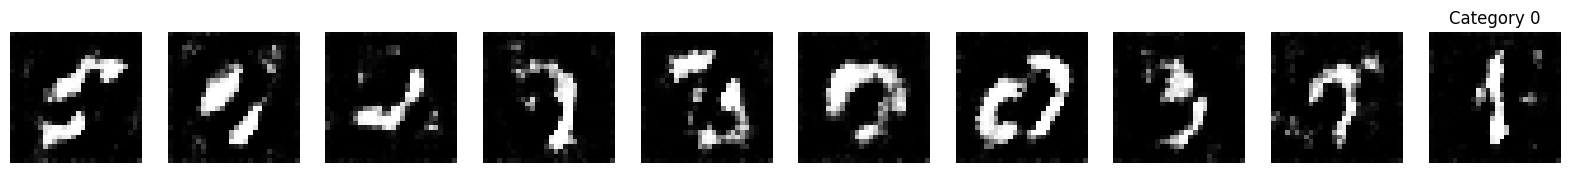

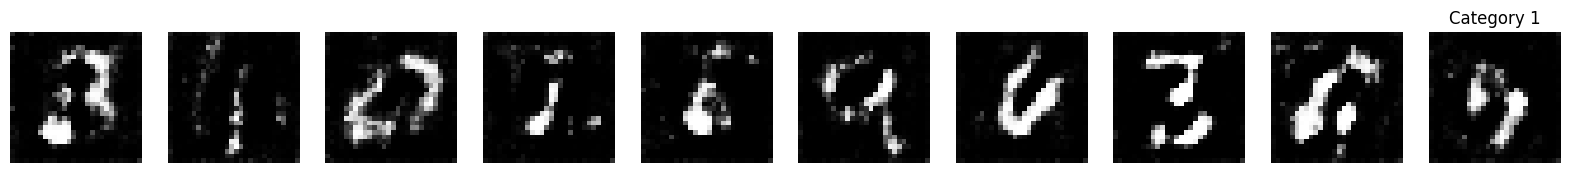

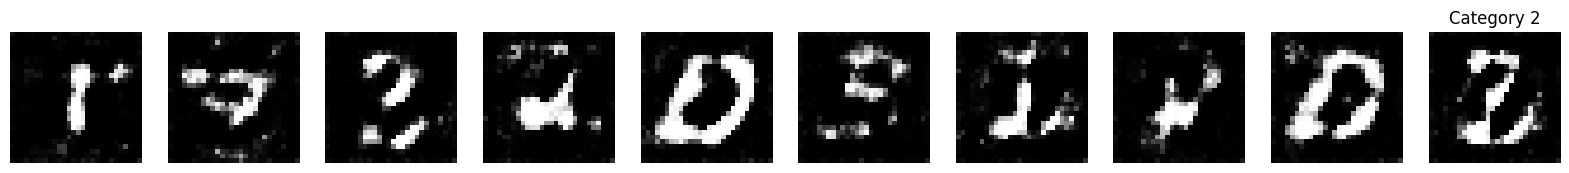

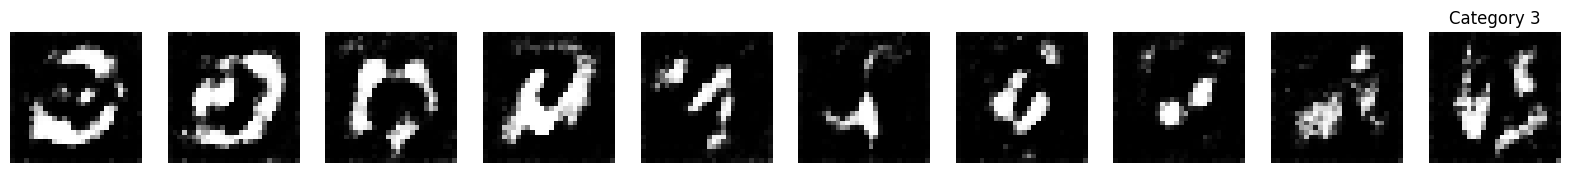

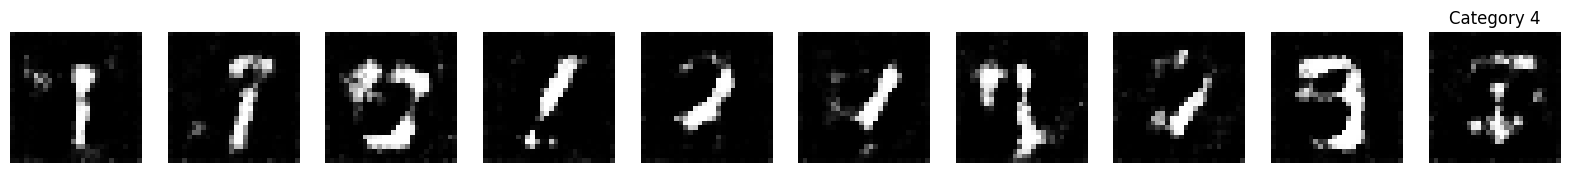

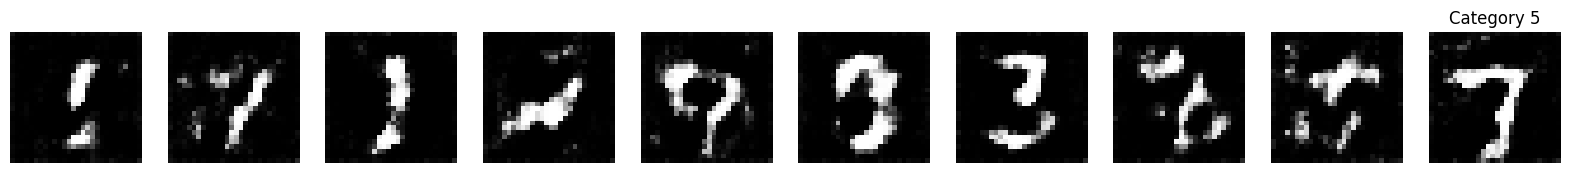

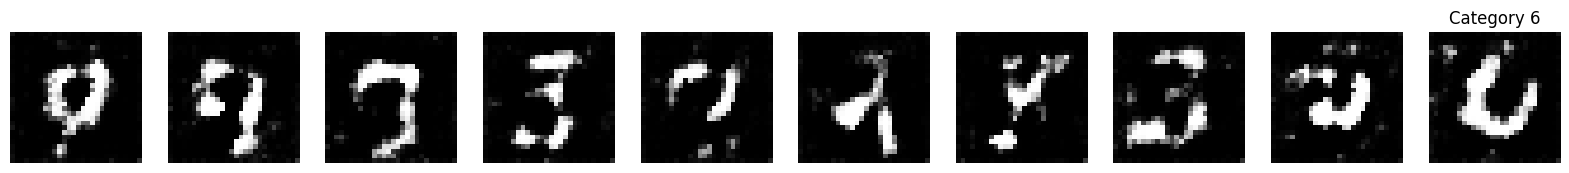

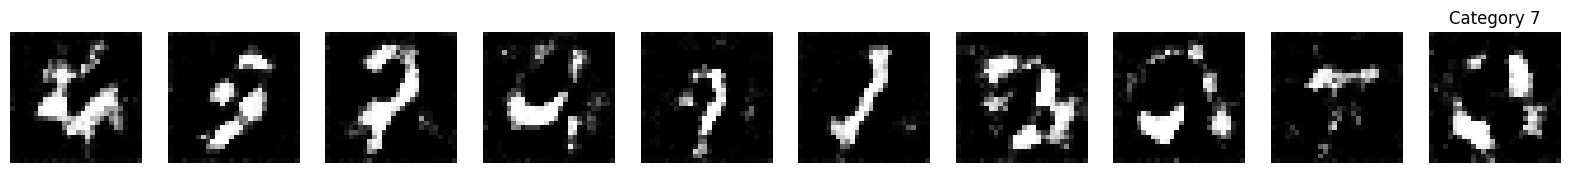

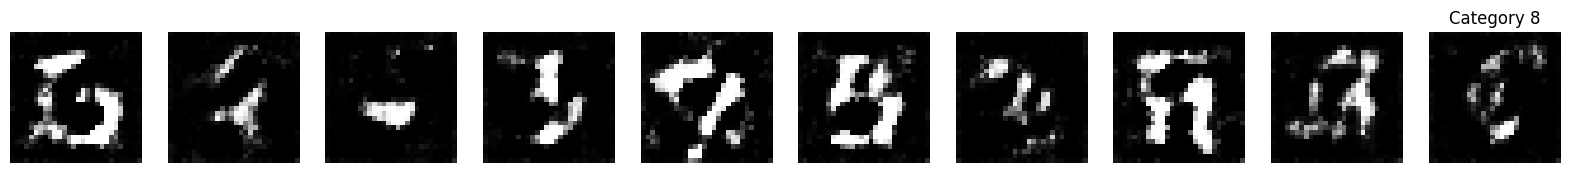

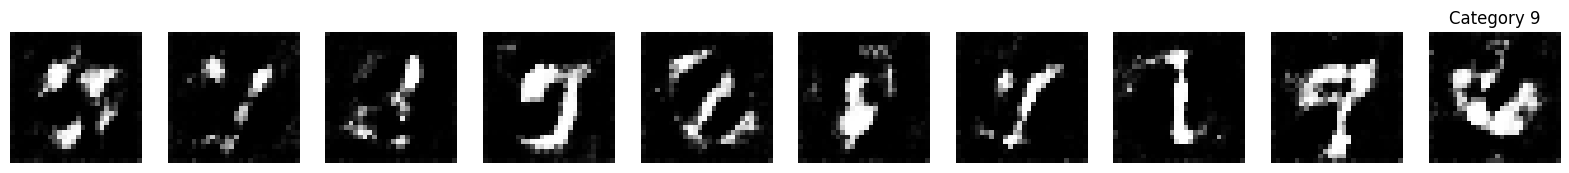

In [3]:
# Example usage
if __name__ == "__main__":
    latent_dim = 62
    categorical_dim = 10
    continuous_dim = 2
    batch_size = 64
    num_epochs = 50

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    infogan = InfoGAN(latent_dim, categorical_dim, continuous_dim)
    train_infogan(infogan, dataloader, num_epochs, device)
    visualize_results(infogan, latent_dim, categorical_dim, continuous_dim)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, latent_dim, categorical_dim, continuous_dim, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim
        self.num_classes = num_classes

        total_dim = latent_dim + categorical_dim + continuous_dim + num_classes

        self.fc1 = nn.Linear(total_dim, 1024)
        self.fc2 = nn.Linear(1024, 128 * 7 * 7)
        self.bn2 = nn.BatchNorm1d(128 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, 2, 1)

    def forward(self, z, c1, c2, labels):
        inputs = torch.cat([z, c1, c2, labels], 1)
        x = F.leaky_relu(self.fc1(inputs), 0.2)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        x = x.view(-1, 128, 7, 7)
        x = F.leaky_relu(self.bn3(self.conv1(x)), 0.2)
        x = torch.tanh(self.conv2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, categorical_dim, continuous_dim, num_classes):
        super(Discriminator, self).__init__()
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(1024, categorical_dim)
        self.fc4 = nn.Linear(1024, continuous_dim)
        self.fc5 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = x.view(-1, 128 * 7 * 7)
        x = F.leaky_relu(self.bn3(self.fc1(x)), 0.2)
        d = torch.sigmoid(self.fc2(x))
        c1 = self.fc3(x)
        c2 = self.fc4(x)
        c_class = self.fc5(x)
        return d, c1, c2, c_class

class ConditionalInfoGAN:
    def __init__(self, latent_dim, categorical_dim, continuous_dim, num_classes, lr=0.0002, beta1=0.5):
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.continuous_dim = continuous_dim
        self.num_classes = num_classes

        self.generator = Generator(latent_dim, categorical_dim, continuous_dim, num_classes)
        self.discriminator = Discriminator(categorical_dim, continuous_dim, num_classes)

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

        self.criterion = nn.BCELoss()
        self.categorical_loss = nn.CrossEntropyLoss()
        self.continuous_loss = nn.MSELoss()
        self.class_loss = nn.CrossEntropyLoss()

    def train_step(self, real_data, labels):
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # One-hot encode the labels
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()

        # Train Discriminator and Q-network
        self.d_optimizer.zero_grad()

        d_real_output, _, _, c_real_class = self.discriminator(real_data)
        d_real_loss = self.criterion(d_real_output, real_labels)
        c_real_loss = self.class_loss(c_real_class, labels)

        z = torch.randn(batch_size, self.latent_dim)
        c1 = torch.zeros(batch_size, self.categorical_dim).scatter_(1, torch.randint(0, self.categorical_dim, (batch_size, 1)), 1)
        c2 = torch.rand(batch_size, self.continuous_dim)
        fake_data = self.generator(z, c1, c2, labels_onehot)
        d_fake_output, q_c1, q_c2, c_fake_class = self.discriminator(fake_data.detach())
        d_fake_loss = self.criterion(d_fake_output, fake_labels)

        q_loss = self.categorical_loss(q_c1, torch.max(c1, 1)[1]) + self.continuous_loss(q_c2, c2)
        c_fake_loss = self.class_loss(c_fake_class, labels)
        d_loss = d_real_loss + d_fake_loss + q_loss + c_real_loss + c_fake_loss
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()

        z = torch.randn(batch_size, self.latent_dim)
        c1 = torch.zeros(batch_size, self.categorical_dim).scatter_(1, torch.randint(0, self.categorical_dim, (batch_size, 1)), 1)
        c2 = torch.rand(batch_size, self.continuous_dim)
        fake_data = self.generator(z, c1, c2, labels_onehot)
        g_fake_output, q_c1, q_c2, c_fake_class = self.discriminator(fake_data)
        g_loss = self.criterion(g_fake_output, real_labels)
        q_loss = self.categorical_loss(q_c1, torch.max(c1, 1)[1]) + self.continuous_loss(q_c2, c2)
        c_fake_loss = self.class_loss(c_fake_class, labels)
        g_total_loss = g_loss + q_loss + c_fake_loss
        g_total_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_total_loss.item(), q_loss.item(), c_real_loss.item(), c_fake_loss.item()

def train_conditional_infogan(cinfogan, dataloader, num_epochs, device):
    cinfogan.generator.to(device)
    cinfogan.discriminator.to(device)

    for epoch in range(num_epochs):
        for i, (real_data, labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            labels = labels.to(device)
            d_loss, g_loss, q_loss, c_real_loss, c_fake_loss = cinfogan.train_step(real_data, labels)

            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'd_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}, q_loss: {q_loss:.4f}, '
                      f'c_real_loss: {c_real_loss:.4f}, c_fake_loss: {c_fake_loss:.4f}')

def visualize_conditional_results(cinfogan, latent_dim, categorical_dim, continuous_dim, num_classes, num_samples=10):
    cinfogan.generator.eval()
    with torch.no_grad():
        for category in range(categorical_dim):
            z = torch.randn(num_samples, latent_dim)
            c1 = torch.zeros(num_samples, categorical_dim)
            c1[:, category] = 1
            c2 = torch.linspace(0, 1, num_samples).unsqueeze(1).repeat(1, continuous_dim)
            
            fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples*2, num_classes*2))
            for class_label in range(num_classes):
                labels_onehot = F.one_hot(torch.full((num_samples,), class_label, dtype=torch.long), num_classes=num_classes).float()
                fake_data = cinfogan.generator(z, c1, c2, labels_onehot)
                fake_data = fake_data.view(num_samples, 28, 28).cpu().numpy()
                
                for j, ax in enumerate(axes[class_label]):
                    ax.imshow(fake_data[j], cmap='gray')
                    ax.axis('off')
                    if j == 0:
                        ax.set_title(f'Class {class_label}')
            plt.suptitle(f'Category {category}')
            plt.tight_layout()
            plt.savefig(f'conditional_infogan_category_{category}.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
            plt.show()


/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Example usage
if __name__ == "__main__":
    latent_dim = 62
    categorical_dim = 10
    continuous_dim = 2
    num_classes = 10  # For MNIST
    batch_size = 64
    num_epochs = 100

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cinfogan = ConditionalInfoGAN(latent_dim, categorical_dim, continuous_dim, num_classes)
    train_conditional_infogan(cinfogan, dataloader, num_epochs, device)
    visualize_conditional_results(cinfogan, latent_dim, categorical_dim, continuous_dim, num_classes)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12214771.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 469767.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3575584.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2533315.00it/s]
/home/ermia/anaconda3/envs/deep-shap/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/100], Step [1/938], d_loss: 9.1420, g_loss: 5.9621, q_loss: 2.9412, c_real_loss: 2.4057, c_fake_loss: 2.2865
Epoch [1/100], Step [101/938], d_loss: 1.4709, g_loss: 0.9555, q_loss: 0.1201, c_real_loss: 0.0972, c_fake_loss: 0.0350
Epoch [1/100], Step [201/938], d_loss: 1.2171, g_loss: 1.1623, q_loss: 0.0818, c_real_loss: 0.2019, c_fake_loss: 0.0139
Epoch [1/100], Step [301/938], d_loss: 0.8395, g_loss: 1.4464, q_loss: 0.0635, c_real_loss: 0.0307, c_fake_loss: 0.0353
Epoch [1/100], Step [401/938], d_loss: 0.8921, g_loss: 1.7412, q_loss: 0.0698, c_real_loss: 0.1463, c_fake_loss: 0.0373
Epoch [1/100], Step [501/938], d_loss: 0.8410, g_loss: 1.9404, q_loss: 0.0996, c_real_loss: 0.2051, c_fake_loss: 0.0277
Epoch [1/100], Step [601/938], d_loss: 0.8717, g_loss: 1.8576, q_loss: 0.1768, c_real_loss: 0.1159, c_fake_loss: 0.0485
Epoch [1/100], Step [701/938], d_loss: 1.0815, g_loss: 1.7931, q_loss: 0.1083, c_real_l